# CSS: Politicians on Wikipedia 

## Which German politicians are captured on Wikipedia? Does search interest predict existence on Wikipedia?

1. Create list of all German politicians between XX and XY
2. Analyse search volume of politicians 
	- 2.1 Plot distribution of number of countries from which search volume happens for male and female politicians
	- 2.2 Plot number of month during which search volume is above threshold for for male and female politicians
3. Binary logistic regression
	- 3.1 Outcome variable: article exists on Wikipedia
	- 3.2 IV: search volume -> number of countries and month
	- 3.3 Control: experience (e.g. how often was a politician already part of parliament)

### Answers

#### Task 1
1. We create a list of all Members of The Bundestag since 2005 until now (2018)
    - Bundestag 2005-2009 (Data: https://www.abgeordnetenwatch.de/api/parliament/bundestag%202005-2009/deputies.json)
    - Bundestag 2009-2013 (Data: https://www.abgeordnetenwatch.de/api/parliament/bundestag%202009-2013/deputies.json)
    - Bundestag 2013-2017 (Data: https://www.abgeordnetenwatch.de/api/parliament/bundestag%202013-2017/deputies.json)
    - Bundestag 2017-     (Data: https://www.abgeordnetenwatch.de/api/parliament/bundestag/deputies.json)

A copy of the original data will be kept.
The Result can be seen in data/memberList.json http://matrode.de:1080/edit/data/memberList.json


#### Task 2
Instructions:
http://matrode.de:1080/view/images/IMG_20180530_113335.jpg
http://matrode.de:1080/view/images/IMG_20180530_113353.jpg

We decided to measure the intrest (over time and by country) relative to the interest of Angela Merkel(who has the highest interest in the past 5 years). Basically we normalize the data.

#### Data Acquisition for Task 2.1 (interest by country) and Task 2.2 (interest by month)
For each politician we make a call to the google trends API, thriugh the library pytrends(a newer version is used, so we have to check if it works in binder, in the final submission).

<img src="images/google_trends_by_region.png" alt="by country" style="width: 400px;"/>
<img src="images/google_trends_over_time.png" alt="by country" style="width: 400px;"/>

The results of the data acquisition will be saved via pickle  to:
**/data/interest_over_time** http://matrode.de:1080/tree/data/interest_over_time
**/data/interest_by_country** http://matrode.de:1080/tree/data/interest_by_country

#### Task 2.1 (interest by country)
Since Google Trends only gives us relative values, we can not compare the results directly.
Here is an Example:

Anegla Merkel  http://matrode.de:1080/tree/images/google_trends_by_region_full.png            |  Martin Schulz http://matrode.de:1080/tree/images/google_trends_by_region_full_schulz.png
:-------------------------:|:-------------------------:
<img src="images/google_trends_by_region_full.png" alt="by country" style="width: 500px;"/>  | <img src="images/google_trends_by_region_full_schulz.png" alt="by country" style="width: 500px;"/>

The highest value always is 100. So it is only how distributed the searches are.
Since most german politicians have the highest search interest in germany, the search interest is relative to the serach interest in germany.



#### Task 2.2 (interest by month)

Anegla Merkel  http://matrode.de:1080/tree/images/google_trends_over_time_full.png            |  Martin Schulz http://matrode.de:1080/tree/images/google_trends_over_time_full_schulz.png
:-------------------------:|:-------------------------:
<img src="images/google_trends_over_time_full.png" alt="by country" style="width: 500px;"/>  | <img src="images/google_trends_over_time_full_schulz.png" alt="by country" style="width: 500px;"/>

### Questions
- In which format to keep the orginal data?
- Should we use the absolute data(the ones given directly) or the relative data(like we did) from Google Trends?
- For 2.2: Do we need to make the step towards the probability?

### Task 3



# Setup

In [153]:
#create data directory where all data used will be downloaded to
import os
dataDirectory="data/"
timeDirectory="interest_over_time"
countryDirectory="interest_by_country"
if not os.path.exists(dataDirectory):
    os.makedirs(dataDirectory)
timePath=os.path.join(dataDirectory, timeDirectory)
if not os.path.exists(timePath):
    os.makedirs(timePath)
countryPath=os.path.join(dataDirectory, countryDirectory)
if not os.path.exists(countryPath):
    os.makedirs(countryPath)
    

In [154]:
#we have to find a solution that works in the binder environment
#!pip3 uninstall pytrends;cd pytrends;python3 setup.py install

# Task 1

In [155]:
#Solution for Task 1: Data Acquisition
#get and save from abgeordnetenwatch.de/api to data
import requests
import urllib
import os
import json

#helper function to convert url to local paths
def toLocalPath(url):
    return os.path.join(dataDirectory, url.replace("/","_"))

parliamentsUrl="https://www.abgeordnetenwatch.de/api/parliaments.json"
parliamentsLocal=toLocalPath(parliamentsUrl)

#the result of this subtask, a list of parliament members
memberList = {}

#if we dont have a local copy, create one
if (not os.path.isfile(parliamentsLocal)): 
    #make a local copy of the parliaments list
    urllib.request.urlretrieve(parliamentsUrl, parliamentsLocal)
    print("Saved parliaments: "+ parliamentsLocal)  


with open(parliamentsLocal) as parliamentsJsonFile:
    
    #load the local copy of the parliaments list file
    parliaments = json.load(parliamentsJsonFile)

    #iterate parliaments
    for parliament in parliaments["parliaments"]:
        
        #restrict to Bundestag, maybe add more alter
        if ("Bundestag" in parliament["name"]):
            
            #get the file pointing to a specific parliament
            parliamentMembersUrl=parliamentName=parliament["datasets"]["deputies"]["by-name"]
            parliamentMembersLocal=toLocalPath(parliamentMembersUrl)
            
            #if we dont have a local copy, create one
            if (not os.path.isfile(parliamentMembersLocal)): 
                #make a local copy of a specific parliament
                urllib.request.urlretrieve(parliamentMembersUrl, parliamentMembersLocal)
                print("Saved parliament: " + parliament["name"] + " to "+ parliamentMembersLocal)
            
            with open(parliamentMembersLocal) as parliamentMembersJsonFile:          
                parliamentMembers = json.load(parliamentMembersJsonFile)
                for parliamentMember in parliamentMembers["profiles"]:
                    #read desired values
                    #we use uuid as id
                    uuid=parliamentMember["meta"]["uuid"]
                    firstName=parliamentMember["personal"]["first_name"]
                    lastName=parliamentMember["personal"]["last_name"]
                    gender=parliamentMember["personal"]["gender"]

                    #test if we already have a member with that uuid in our member list
                    if(uuid in memberList):
                        #update "numberOfParliaments"
                        memberList[uuid]["numberOfParliaments"]=memberList[uuid]["numberOfParliaments"]+1
                    else:
                        #create new member entry
                        memberList[uuid] = {
                            "firstName" :firstName,
                            "lastName" :lastName,
                            "gender" :gender,
                            "numberOfParliaments":1
                        }

#Save members list
memberListJsonPath=os.path.join(dataDirectory,"memberList.json")
with open(memberListJsonPath, 'w') as memberListJsonFile:
    json.dump(memberList, memberListJsonFile, sort_keys=True, indent=4)

print("members saved to: "+memberListJsonPath)

members saved to: data/memberList.json


# Task2

# Data Acquisition for Task 2.1 (Interest by country) and Task 2.2 (Interest over time)

In [174]:
#Data Acquisition Task 2.1 and 2.2
import os
import urllib
import json
import pickle
import pytrends
import pandas as pd
from pytrends.request import TrendReq

dataDirectory="data"
#create a new directory for the data/interest_by_country
countryDirectory="interest_by_country"
timeDirectory="interest_over_time"
meberListJsonPath=os.path.join(dataDirectory, "memberList.json")

#create output data strcuture
resultDataFrame = pd.DataFrame(columns=["uuid","firstName", "lastName", "gender", "countryCount", "timeCount"])


#open members list containing the politicians
with open(meberListJsonPath) as meberListJsonFile:
    #load the local copy of the parliaments list file
    members = json.load(meberListJsonFile)
    
    #for each politician, represented by the uuid
    for memberUuid in members:
        
        countryPath=os.path.join(dataDirectory, countryDirectory, memberUuid+".pickle")
        timePath=os.path.join(dataDirectory, timeDirectory, memberUuid+".pickle")
        #get firstName, lastName and gender
        firstName = members[memberUuid]["firstName"]
        lastName = members[memberUuid]["lastName"]
        gender = members[memberUuid]["gender"]

        fullName = firstName +" " + lastName
        
        #if we have no saved file, do a google trebds request
        if (not os.path.isfile(countryPath)) and (not os.path.isfile(timePath)): 
        
            print("Working on " +fullName)
            pytrends = TrendReq(hl='de-DE', tz=360)
            keywords = [fullName, "Angela Merkel"]
            #cat=396 is the category for politics on google trends
            pytrends.build_payload(keywords, cat=396, timeframe='today 5-y', geo='', gprop='')
            countryDataframe = pd.DataFrame(pytrends.interest_by_region(resolution='COUNTRY'))
            #TODO this get the weeks not the desired month 
            timeDataframe = pd.DataFrame(pytrends.interest_over_time())
            
            #save to disk
            countryDataframe.to_pickle(countryPath)
            timeDataframe.to_pickle(timePath)
            
            sleep(30)
            
        #if the a saved file use this    
        else:
            #print progress
            print('.', end='')
            countryDataframe=pickle.load(open(countryPath, 'rb')) 
            timeDataframe=pickle.load(open(timePath, 'rb')) 
            
        #count in how many countries we have a search interest above zero
        countryCount=len(countryDataframe[fullName].nonzero()[0])
        timeCount=len(timeDataframe[fullName].nonzero()[0])
        
        #populate dataframe
        resultDataFrame = resultDataFrame.append({
            "uuid": memberUuid,
            "firstName": firstName,
            "lastName":lastName,
            "gender": gender,
            "countryCount": countryCount,
            "timeCount": timeCount,
        }, ignore_index=True)

        
#Save members list
memberInterestListPath=os.path.join(dataDirectory,"memberInterestList.pickle")
resultDataFrame.to_pickle(memberInterestListPath)
print("got search interest by country and by time for: "+str(len(resultDataFrame.index))+" politicians")

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

# Task 2.1 (Interest by country)

Search interest from 0 countries, female:415 male: 853


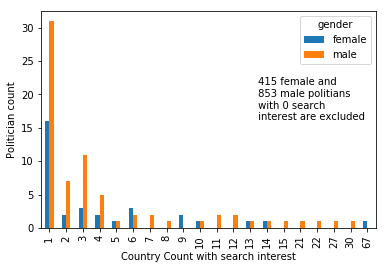

In [171]:
#2.1 Plot the data
%matplotlib inline
import os
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#load data
dataDirectory="data"
df=pickle.load(open(os.path.join(dataDirectory,"memberInterestList.pickle"), 'rb')) 

#combine the dataframes
counts=df.groupby(["countryCount","gender"])["countryCount"].count().drop([0]).unstack()
plot=counts.plot(kind="bar")

#set labels
plot.set_xlabel("Country Count with search interest")
plot.set_ylabel("Politician count")

#get ignored values
femaleDropped=df[(df.gender=="female")]["countryCount"].value_counts()[0]
maleDropped=df[(df.gender=="male")]["countryCount"].value_counts()[0]

#add a remark that we removed 0 values
plt.figtext(.62, .50, " "+str(femaleDropped)+ " female and\n "+str(maleDropped)+" male politians\n with 0 search\n interest are excluded")
print("Search interest from 0 countries, female:"+ str(femaleDropped)+" male: "+str(maleDropped))

# Task 2.2 (interest over time)

                                   uuid   firstName        lastName  gender  \
0  001007ba-e35a-4e69-9c66-e018823a62ef     Mathias           Stein    male   
1  0077079d-5136-4c5a-96c0-ef8ee76ccfe3        Ulli          Nissen  female   
2  00c1508c-e69f-4813-9bd9-4607b9d8d9a7  Heidemarie  Wieczorek-Zeul  female   
3  00e01ad7-e772-4198-b964-8ae1e5cd7e6c     Florian          Toncar    male   
4  014490fc-3403-4255-b92d-175816269937      Ursula  Groden-Kranich  female   

  countryCount timeCount  
0            0         0  
1            0         0  
2            0         1  
3            0         0  
4            0         0  


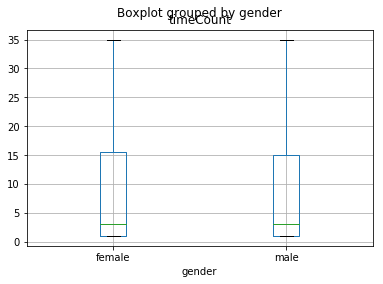

In [179]:
#2.2 Plot the data
%matplotlib inline
import os
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#load data
dataDirectory="data"
df=pickle.load(open(os.path.join(dataDirectory,"memberInterestList.pickle"), 'rb')) 

#split by gender
#TODO: im not sure about this
df[df["timeCount"]>0].boxplot(column="timeCount",by="gender",showfliers=False)

#set labels
plot.set_xlabel("Gender")
plot.set_ylabel("Number of weeks")

#get ignored values
femaleDropped=len(df[((df.gender=="female") & (df.timeCount=="0"))])
maleDropped=len(df[((df.gender=="male") & (df.timeCount=="0"))])

#add a remark that we removed 0 values
#plt.figtext(.7, .6, " politians with 0\n weeks of search\n interest are\n excluded")

#print("Search interest of 0 weeks, female:"+ str(femaleDropped)+" male: "+str(maleDropped))

#debug
print(df.head(5))

# Code snippet for testing if wiki page exists

In [149]:
#Function to test if wiki page exists

def wikiPageExists(fristName, lastName, language):
 #build the query string for the wiki api
    payload = {"action":"query",
               "list": "search",
               "srsearch":"{firstName} {lastName}".format(firstName=firstName, lastName=lastName),
               "format":"json"}
    encodedPayload = urlencode(payload)

    #build wikipedia api url
    ##example document: https://de.wikipedia.org/w/api.php?action=query&list=search&srsearch=Angela+Merkel&format=json
    wikiUrl="https://{language}.wikipedia.org/w/api.php?{encodedPayload}".format(language=language, encodedPayload=encodedPayload)

    result={}

    #we use try to avoid errors if no such page exists
    try:
        wikiSearch = json.load(urllib.request.urlopen(wikiUrl))

        #read the attributes and from wikipedia and put in result of the function
        result["wikiTitle"] = wikiSearch["query"]["search"][0]["title"]
        result["wikipageId"] = wikiSearch["query"]["search"][0]["pageid"]
        result["wikipageSnippet"] = wikiSearch["query"]["search"][0]["snippet"]
        #page exists
        result["exists"]=True
        
        #debug
        #print("Name: {firstName} {lastName}, language: {language} pageid: {pageId}, title: {pageTitle} url: https://{language}.wikipedia.org/wiki/{pageTitleQuoted}"
        #      .format(firstName=firstName, lastName=lastName, language=language, pageId=pageId, pageTitle=pageTitle, pageTitleQuoted=urllib.parse.quote(pageTitle)))

        #TODO check if its the right person, maybe use some categories, or search the snippet for information

    except IndexError:
        #page does not exists
        result["exists"]=False
        #print("Name: {firstName} {lastName}, language: {language} does not exists!"
        #      .format(firstName=firstName, lastName=lastName, language=language ))
        
    return result


In [150]:
#get information from wikipedia
wikiResult=wikiPageExists("Angela", "Merkel", "de")

wikiResult["exists"]
wikiResult["wikiTitle"]

NameError: name 'urlencode' is not defined

# Code snippet for pytrends

In [180]:

import pandas as pd
import pytrends
from pytrends.request import TrendReq

pytrends = TrendReq(hl='en', tz=360)
kw_list = ["Angela Merkel", "Martin Schulz"]
#cat=396 is the category for politics on google trends, sse here: https://github.com/pat310/google-trends-api/wiki/Google-Trends-Categories
pytrends.build_payload(kw_list, cat=396, timeframe='today 5-y', geo='', gprop='')

print(pytrends.interest_over_time().head(5))
print(pytrends.interest_by_region(resolution='COUNTRY').head(5))


            Angela Merkel  Martin Schulz isPartial
date                                              
2013-06-09              8              0     False
2013-06-16             13              1     False
2013-06-23             10              1     False
2013-06-30              8              1     False
2013-07-07              6              1     False
                Angela Merkel  Martin Schulz
geoName                                     
Afghanistan                 0              0
Albania                     0              0
Algeria                   100              0
American Samoa              0              0
Andorra                     0              0
